In [ ]:
!pip install tensorflow

In [ ]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from shutil import copyfile
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
drive_path = '/content/drive/Shareddrives'

Mounted at /content/gdrive


In [ ]:
# grader-required-cell

source_path = '/content/gdrive/Shareddrives/Animals_Pictures/Animals_picture/' #KALAU GANTI LOKASI, HARUS GANTI#

categories = os.listdir(source_path)
print(f"Categories found : {categories}")

Categories found : ['chimpanzee', 'Jaguar', 'Lion']


In [ ]:
root_dir = '/animals_dataset'

# Empty directory to prevent FileExistsError if the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
    os.makedirs(root_path)
    train_dir = os.path.join(root_path, 'training')
    val_dir = os.path.join(root_path, 'validation')
    test_dir = os.path.join(root_path, 'testing')

    for category in os.listdir(source_path):
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)
        test_category_dir = os.path.join(test_dir, category)
        os.makedirs(train_category_dir)
        os.makedirs(val_category_dir)
        os.makedirs(test_category_dir)

try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# Verify the creation of directories
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/animals_dataset/testing
/animals_dataset/validation
/animals_dataset/training
/animals_dataset/testing/Jaguar
/animals_dataset/testing/Lion
/animals_dataset/testing/chimpanzee
/animals_dataset/validation/Jaguar
/animals_dataset/validation/Lion
/animals_dataset/validation/chimpanzee
/animals_dataset/training/Jaguar
/animals_dataset/training/Lion
/animals_dataset/training/chimpanzee


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE, SPLIT_SIZE_TEST):
    file_list = [f for f in os.listdir(SOURCE_DIR) if os.path.getsize(os.path.join(SOURCE_DIR, f)) > 0]

    train_num_items = int(round(len(file_list) * SPLIT_SIZE, 0))
    train_list = random.sample(file_list, train_num_items)
    remain_list = list(set(file_list) - set(train_list))
    test_num_items = int(round(len(remain_list) * SPLIT_SIZE_TEST / (1 - SPLIT_SIZE), 0))
    test_list = random.sample(remain_list, test_num_items)
    val_list = list(set(remain_list) - set(test_list))

    for f in train_list:
        copyfile(os.path.join(SOURCE_DIR, f), os.path.join(TRAINING_DIR, f))
    for f in test_list:
        copyfile(os.path.join(SOURCE_DIR, f), os.path.join(TESTING_DIR, f))
    for f in val_list:
        copyfile(os.path.join(SOURCE_DIR, f), os.path.join(VALIDATION_DIR, f))

# Directories for training, validation, and testing
TRAINING_DIR = os.path.join(root_dir, "training/")
VALIDATION_DIR = os.path.join(root_dir, "validation/")
TESTING_DIR = os.path.join(root_dir, "testing/")

split_size = 0.6
split_size_test = 0.2

# Split the data for each category
for category in os.listdir(source_path):
    SOURCE_DIR_CATEGORY = os.path.join(source_path, category)
    TRAINING_CATEGORY_DIR = os.path.join(TRAINING_DIR, category)
    VALIDATION_CATEGORY_DIR = os.path.join(VALIDATION_DIR, category)
    TESTING_CATEGORY_DIR = os.path.join(TESTING_DIR, category)

    # Clean up existing files if present
    for dir_path in [TRAINING_CATEGORY_DIR, VALIDATION_CATEGORY_DIR, TESTING_CATEGORY_DIR]:
        for file in os.scandir(dir_path):
            os.remove(file.path)

    split_data(SOURCE_DIR_CATEGORY, TRAINING_CATEGORY_DIR, VALIDATION_CATEGORY_DIR, TESTING_CATEGORY_DIR, split_size, split_size_test)

    print(f"\n\nOriginal '{category}' directory has {len(os.listdir(SOURCE_DIR_CATEGORY))} images")
    print(f"There are {len(os.listdir(TRAINING_CATEGORY_DIR))} images of {category} for training")
    print(f"There are {len(os.listdir(VALIDATION_CATEGORY_DIR))} images of {category} for validation")
    print(f"There are {len(os.listdir(TESTING_CATEGORY_DIR))} images of {category} for testing")



Original 'chimpanzee' directory has 50 images
There are 30 images of chimpanzee for training
There are 10 images of chimpanzee for validation
There are 10 images of chimpanzee for testing


Original 'Jaguar' directory has 30 images
There are 18 images of Jaguar for training
There are 6 images of Jaguar for validation
There are 6 images of Jaguar for testing


Original 'Lion' directory has 32 images
There are 19 images of Lion for training
There are 7 images of Lion for validation
There are 6 images of Lion for testing


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        target_size=(224, 224))

    validation_datagen = ImageDataGenerator(rescale=1.0/255)

    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode='categorical',
                                                                  target_size=(224, 224))
    return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)


Found 67 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


In [ ]:
for images, labels in train_generator:
    print(images.shape)  # Output: (batch_size, 224, 224, 3)
    break


(32, 224, 224, 3)


In [ ]:
def create_model():
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(categories), activation='softmax')  # Dynamically set the number of output classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 27561795 (105.14 MB)
Trainable params: 12847107 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
______

In [ ]:
print(next(iter(train_generator))[0].shape)
print(next(iter(validation_generator))[0].shape)


(3, 224, 224, 3)
(23, 224, 224, 3)


In [ ]:
import math

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)
callbacks_list = [lrate]

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.00000001,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[lr_callback, lrate, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
3/3 [==============================] - 76s 4s/step - loss: 1.7009 - accuracy: 0.4030 - val_loss: 0.8107 - val_accuracy: 0.6957 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/100
3/3 [==============================] - 1s 394ms/step - loss: 1.0787 - accuracy: 0.4925 - val_loss: 0.8415 - val_accuracy: 0.3913 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/100
3/3 [==============================] - 2s 718ms/step - loss: 0.7815 - accuracy: 0.6119 - val_loss: 0.7220 - val_accuracy: 0.6522 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/100
3/3 [==============================] - 1s 427ms/step - loss: 0.7379 - accuracy: 0.7164 - val_loss: 0.7507 - val_accuracy: 0.6522 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
3/3 [============================

In [ ]:
testing_datagen = ImageDataGenerator(rescale=1.0/255.)
testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        target_size=(224, 224))

# Evaluate the model on test data
results = model.evaluate(testing_generator, batch_size=32)
print("Test loss, Test accuracy:", results)

Found 22 images belonging to 3 classes.
1/1 [==============================] - 0s 284ms/step - loss: 0.4935 - accuracy: 0.7273
Test loss, Test accuracy: [0.4934558570384979, 0.7272727489471436]


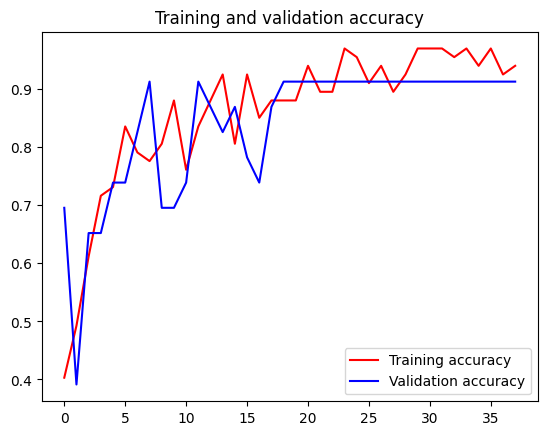

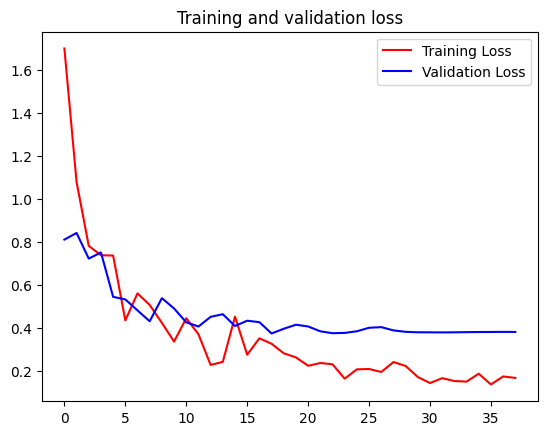

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the model
model_save_path = '/content/gdrive/MyDrive/animal_model.h5'
model.save(model_save_path)

# Load the model
loaded_model = tf.keras.models.load_model(model_save_path)